In [1]:
#%reset # only run when space is needed (variables will be deleted from memory)

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  only, please run `%reset?` for details
Don't know how to reset  run, please run `%reset?` for details
Don't know how to reset  when, please run `%reset?` for details
Don't know how to reset  space, please run `%reset?` for details
Don't know how to reset  is, please run `%reset?` for details
Don't know how to reset  needed, please run `%reset?` for details
Don't know how to reset  (variables, please run `%reset?` for details
Don't know how to reset  will, please run `%reset?` for details
Don't know how to reset  be, please run `%reset?` for details
Don't know how to reset  deleted, please run `%reset?` for details
Don't know how to reset  from, please run `%reset?` for details
Don't know how to reset  memory), please run `%reset?` for details


In [1]:
import pandas as pd  # operate with dataframes
import scipy.io  # to load Matlab data
import matplotlib.pyplot as plt  # mother of plots for Python
import seaborn as sns  
import numpy as np  # array/matrix operations (e.g. linear algebra)
from cmcrameri import cm
import scipy.signal
import pyxdf
from scipy.ndimage import gaussian_filter1d
from statsmodels import robust
from scipy.stats import median_abs_deviation
from PIL import Image
from scipy.stats import f_oneway
from scipy.io import savemat
import random
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
PATH_REPO = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline"
PATH_FOREYE = f"{PATH_REPO}/data/village/processed/MAD_sacc_newfile" # new path, potentially change
PATH_TRG = f"{PATH_REPO}/data/village/processed/Trigger_MAD_newfile"
PATH_MATLABPLOTS = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/processed/face_paper"
PATH_ERPS = "/net/store/nbp/projects/wd_ride_village/processedData/village/preprocessed/"
PATH_EEG = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/processed/EEG"
PATH_PROC = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/processed"
PATH_RAW = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/raw"


In [3]:
recordings = pd.read_csv(f"{PATH_REPO}/recordings_village.csv", index_col=0)
# only keep the subjects we will include in the paper!

subs_to_include = [1,4,5,11,16,18,19,20,21,29,30,33,34,36,37,38,41,
                   42,43,44,45,46,47,48,49,50,53,54,56,57,58,59,60]


recordings["files"] = [
    int(f[:2]) if int(f[:2]) in subs_to_include else 0
    for f in recordings["file"]
]

recordings = recordings[recordings["files"] > 0]

recordings = recordings.drop("files", axis=1)



In [4]:
# color pallet used in the paper
# blue
gaze_color_1 = "#066da8"#"#0570b0"

# red
sacc_color_1 = "#e31a1c" #d

# green
vel_eye_color = "#238443" #d

bgrd_color='#66c2a5'
body_color='#fc8d62'
head_color='#8da0cb'

# Create shifted trigger files

In [14]:
##### Gaze Onset!
# participants ids
ids = recordings.index.tolist()
#idd = ids[13:]
idd = ids[:]

shift_corr = 1
shift_two = ["1dea5bd2-80d1-4068-b512-99c55f85f44c",
             '9c8b7189-b11a-4014-a2ea-3848cc68e7e3',]
shift_three = ["70656182-09b3-4c19-9ae2-0a2ab2e19fed","391543f6-7ff0-4ed3-aefd-c0ef68ebbbf3",
               '0e1d6bec-59fb-4faf-9ccb-0c4f4c52ddab','312425d7-bb57-49dc-9107-b6462b3c176c',
               'd6610468-645c-4e29-bef0-ce2ad45a5c3f',"bbd5f09e-6213-4c23-ad25-f63cd0c38b17",
               "4facb3ab-dfba-4953-b266-6368edac48d3",'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7',
               'e9b010ec-29a3-4084-88e8-832f8e33a6c8','ce4afb7b-f192-4726-87ef-2497b247648e']
shift_four = ["c924cc42-5987-4025-b026-c672e304599f","fdc06350-e1bb-4630-9d23-6631bb0a9498",
              "42785e0b-efab-44a1-8c9f-bab59edcc93e",]

added_end = 0
end_more = ['0b462e46-9a87-4e70-ab1d-0f53c35726ec','95184b7a-42f1-40b0-ae36-be6ef1e33f1d',
            'c4cb86a2-c2d6-40f0-b594-9bb3eb769189',"bbd5f09e-6213-4c23-ad25-f63cd0c38b17",
           'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7']
end_less = ['b3cee177-543e-4398-9075-5b671eed84ab','f25b9349-573e-4c97-974e-855d4b037c79',
            '6f6719eb-8c89-46fe-8b5e-3c81e0e40a84','16ae5535-ea8c-4ae2-9195-ef3abf811f97',
            '3aee7a2a-9c98-4af9-8bdc-b6b3ba8c73e1','ac35237b-e4b2-4744-bd17-02f44c3f6139']

for uid in idd:
    display(uid)
    
    # for some, we need additional linear drift correction
    if uid in shift_two:
        shift_corr = 2
    elif uid in shift_three:
        shift_corr = 3
    elif uid in shift_four:
        shift_corr = 4

    if uid in end_more:
        added_end = 0.022
    elif uid in end_less:
        added_end = -0.011
        
    # load raw data
    part = recordings.loc[uid].file
    
    data, _ = pyxdf.load_xdf(f"{PATH_RAW}/{part}")

    starts = []
    names = []
    ends = []
    # get the new time:
    for s in data:
        # stream name
        s_name = s["info"]["name"][0]
        # check SR of the EEG data
        if "openvibeSignal" in s_name:
            time_eeg = s["time_stamps"][0]
            time_eeg_end = s["time_stamps"][-1]
        elif "openvibeMarkers" not in s_name:
            starts.append(s["time_stamps"][0])
            names.append(s_name)
            ends.append(s["time_stamps"][-1])
        if "EyeTrackingWorld" in s_name:
            et_start = s["time_stamps"][0]

    to_sub = et_start - min(starts)  # this is done to correct for the onset
    start = min(starts) - time_eeg
    # TBD: decide which end to use!!!
    end_e = ends[starts.index(min(starts))] - time_eeg_end
    end = max(ends) - time_eeg_end
    if end > 0.2:
        end = end_e
    end = end + added_end 

    # load data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)


    # correct unity with the different timestamps
    time = for_eye["time"].tolist() + to_sub
    time = [round(t, 3) for t in time]

    # interpolate the timestamps but save previous version
    ts = np.linspace(time[0], time[-1], num=int(time[-1] * 1000))
    ts = [round(t, 3) for t in ts]
    ts = list(dict.fromkeys(ts))  # remove dublicates
    
    # add shift
    dynamic_shift = end - start

    drift_correction_np = np.linspace(
        0, (dynamic_shift*shift_corr), len(ts)
    )  # np.linspace(start,end,num)
    
    # linearly correct the timestamps from start to end given the drift increase over time 'dynamic_shift'
    ts_shift = (ts - drift_correction_np).tolist()

    # take interpolated ts out
    time_df = pd.DataFrame(
        list(zip(ts, ts_shift)), columns=["time", "time_shift"]
    )
    time_df = time_df[time_df["time"].isin(time)]

    # exchange the times in for_eye
    for_eye["time"] = time_df["time_shift"].tolist()
    for_eye["pos_time"] = for_eye["time"].shift(-1) # n has the timestamp of sample n+1
    for_eye["neg_time"] = for_eye["time"].shift(1) # n has the timestamp of sample n-1
    for_eye = for_eye.iloc[1:-1]

    # create triggers as done in the code before
    # variables
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    pos_time = gaze["pos_time"].tolist()
    neg_time = gaze["neg_time"].tolist()
    
    no_name = gaze[gaze["names"].isnull()]
    gaze = gaze[~gaze["names"].isnull()]
    bg_gaze = gaze[~gaze["names"].str.contains("NPC|face")]
    body_gaze = gaze[gaze["names"].str.contains("NPC", regex=False, na=False)]
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]


    # create the trigger df:
    # first get all the starts in one column
    lat = pd.concat([bg_gaze["time"], body_gaze["time"], face_gaze["time"], no_name["time"]])
    lat = pd.DataFrame(lat)

    # then add the type: 2 for background, 1 for NPCs and 0 for faces, 3 for no name
    lat["type"] = (
        [2] * len(bg_gaze["time"])
        + [1] * len(body_gaze["time"])
        + [0] * len(face_gaze["time"])
        + [3] * len(no_name["time"])
    )
    

    # sort it by start so that all the events are in correct order
    lat = lat.sort_values(by=["time"])
    # rename start to latency
    lat = lat.rename(columns={"time": "latency"})

    lat.to_csv(f"{PATH_TRG}/TRF_gazeOnset_no_shift_{uid}.csv", index=False)
    lat["latency"] = neg_time
    lat.to_csv(f"{PATH_TRG}/TRF_gazeOnset_neg_shift_{uid}.csv", index=False)
    lat["latency"] = pos_time
    lat.to_csv(f"{PATH_TRG}/TRF_gazeOnset_pos_shift_{uid}.csv", index=False)

    
    

'70656182-09b3-4c19-9ae2-0a2ab2e19fed'

'c924cc42-5987-4025-b026-c672e304599f'

'20e8d35c-e7aa-4be3-a6e2-5b78f4cd44d8'

'1dea5bd2-80d1-4068-b512-99c55f85f44c'

'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7'

'289c15b5-ddd9-442b-b6b6-78df542beb3a'

'61c0f1aa-b3ef-497b-8b6e-8ec6f05f6c42'

'391543f6-7ff0-4ed3-aefd-c0ef68ebbbf3'

'95184b7a-42f1-40b0-ae36-be6ef1e33f1d'

'c4cb86a2-c2d6-40f0-b594-9bb3eb769189'

'b3cee177-543e-4398-9075-5b671eed84ab'

'623664e8-1ceb-48e0-abd0-46d447285980'

'f25b9349-573e-4c97-974e-855d4b037c79'

'0e1d6bec-59fb-4faf-9ccb-0c4f4c52ddab'

'817cb93e-061d-4ea6-a13d-31226246ff34'

'6f6719eb-8c89-46fe-8b5e-3c81e0e40a84'

'42785e0b-efab-44a1-8c9f-bab59edcc93e'

'd6610468-645c-4e29-bef0-ce2ad45a5c3f'

'6264954d-ddee-4eff-b8d6-887fb28524f9'

'653c0570-e662-47a1-89ea-d2125edc680e'

'312425d7-bb57-49dc-9107-b6462b3c176c'

'16ae5535-ea8c-4ae2-9195-ef3abf811f97'

'e9b010ec-29a3-4084-88e8-832f8e33a6c8'

'983f9d22-737a-4087-b812-3b1ce7e29fed'

'3aee7a2a-9c98-4af9-8bdc-b6b3ba8c73e1'

'9c8b7189-b11a-4014-a2ea-3848cc68e7e3'

'4facb3ab-dfba-4953-b266-6368edac48d3'

'ac35237b-e4b2-4744-bd17-02f44c3f6139'

'cac2d463-04e5-400f-92fb-d731d1f31e79'

'e73b2026-7205-48b2-a1e4-7434a8c918f6'

'0b462e46-9a87-4e70-ab1d-0f53c35726ec'

'3fa44c7e-1ea4-4625-9576-b489cfc918b3'

'ea12ade9-532c-4a5f-b5c5-38ee71a59b9f'

In [141]:
ids = recordings.index.tolist()
idd = ids[10:11]
idd

['b3cee177-543e-4398-9075-5b671eed84ab']

In [6]:
##### Saccade Onset!
# participants ids
ids = recordings.index.tolist()
#idd = ids[13:]
idd = ids[:]

shift_corr = 1
shift_two = ["1dea5bd2-80d1-4068-b512-99c55f85f44c",
             '9c8b7189-b11a-4014-a2ea-3848cc68e7e3',]
shift_three = ["70656182-09b3-4c19-9ae2-0a2ab2e19fed","391543f6-7ff0-4ed3-aefd-c0ef68ebbbf3",
               '0e1d6bec-59fb-4faf-9ccb-0c4f4c52ddab','312425d7-bb57-49dc-9107-b6462b3c176c',
               'd6610468-645c-4e29-bef0-ce2ad45a5c3f',"bbd5f09e-6213-4c23-ad25-f63cd0c38b17",
               "4facb3ab-dfba-4953-b266-6368edac48d3",'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7',
               'e9b010ec-29a3-4084-88e8-832f8e33a6c8','ce4afb7b-f192-4726-87ef-2497b247648e']
shift_four = ["c924cc42-5987-4025-b026-c672e304599f","fdc06350-e1bb-4630-9d23-6631bb0a9498",
              "42785e0b-efab-44a1-8c9f-bab59edcc93e",]

added_end = 0
end_more = ['0b462e46-9a87-4e70-ab1d-0f53c35726ec','95184b7a-42f1-40b0-ae36-be6ef1e33f1d',
            'c4cb86a2-c2d6-40f0-b594-9bb3eb769189',"bbd5f09e-6213-4c23-ad25-f63cd0c38b17",
           'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7']
end_less = ['b3cee177-543e-4398-9075-5b671eed84ab','f25b9349-573e-4c97-974e-855d4b037c79',
            '6f6719eb-8c89-46fe-8b5e-3c81e0e40a84','16ae5535-ea8c-4ae2-9195-ef3abf811f97',
            '3aee7a2a-9c98-4af9-8bdc-b6b3ba8c73e1','ac35237b-e4b2-4744-bd17-02f44c3f6139']

for uid in idd:
    display(uid)
    
    # for some, we need additional linear drift correction
    if uid in shift_two:
        shift_corr = 2
    elif uid in shift_three:
        shift_corr = 3
    elif uid in shift_four:
        shift_corr = 4

    if uid in end_more:
        added_end = 0.022
    elif uid in end_less:
        added_end = -0.011
        
    # load raw data
    part = recordings.loc[uid].file
    
    data, _ = pyxdf.load_xdf(f"{PATH_RAW}/{part}")

    starts = []
    names = []
    ends = []
    # get the new time:
    for s in data:
        # stream name
        s_name = s["info"]["name"][0]
        # check SR of the EEG data
        if "openvibeSignal" in s_name:
            time_eeg = s["time_stamps"][0]
            time_eeg_end = s["time_stamps"][-1]
        elif "openvibeMarkers" not in s_name:
            starts.append(s["time_stamps"][0])
            names.append(s_name)
            ends.append(s["time_stamps"][-1])
        if "EyeTrackingWorld" in s_name:
            et_start = s["time_stamps"][0]

    to_sub = et_start - min(starts)  # this is done to correct for the onset
    start = min(starts) - time_eeg
    # TBD: decide which end to use!!!
    end_e = ends[starts.index(min(starts))] - time_eeg_end
    end = max(ends) - time_eeg_end
    if end > 0.2:
        end = end_e
    end = end + added_end 

    # load data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)


    # correct unity with the different timestamps
    time = for_eye["time"].tolist() + to_sub
    time = [round(t, 3) for t in time]

    # interpolate the timestamps but save previous version
    ts = np.linspace(time[0], time[-1], num=int(time[-1] * 1000))
    ts = [round(t, 3) for t in ts]
    ts = list(dict.fromkeys(ts))  # remove dublicates
    
    # add shift
    dynamic_shift = end - start

    drift_correction_np = np.linspace(
        0, (dynamic_shift*shift_corr), len(ts)
    )  # np.linspace(start,end,num)
    
    # linearly correct the timestamps from start to end given the drift increase over time 'dynamic_shift'
    ts_shift = (ts - drift_correction_np).tolist()

    # take interpolated ts out
    time_df = pd.DataFrame(
        list(zip(ts, ts_shift)), columns=["time", "time_shift"]
    )
    time_df = time_df[time_df["time"].isin(time)]

    # exchange the times in for_eye
    for_eye["time"] = time_df["time_shift"].tolist()
    for_eye["pos_time"] = for_eye["time"].shift(-1) # n has the timestamp of sample n+1
    for_eye["neg_time"] = for_eye["time"].shift(1) # n has the timestamp of sample n-1
    #for_eye = for_eye.iloc[:]
    
    # create triggers as done in the code before
    # variables
    gaze = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)]
    gaze["time"] = gaze["time"].shift(1)
    gaze["pos_time"] = gaze["pos_time"].shift(1)
    gaze["neg_time"] = gaze["neg_time"].shift(1)
    
    gaze = gaze[gaze["time"].notna()]

    gaze = gaze[gaze["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  

    pos_time = gaze["pos_time"].tolist()
    neg_time = gaze["neg_time"].tolist()
    
    no_name = gaze[gaze["names"].isnull()]
    gaze = gaze[~gaze["names"].isnull()]
    bg_gaze = gaze[~gaze["names"].str.contains("NPC|face")]
    body_gaze = gaze[gaze["names"].str.contains("NPC", regex=False, na=False)]
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]


    # create the trigger df:
    # first get all the starts in one column
    lat = pd.concat([bg_gaze["time"], body_gaze["time"], face_gaze["time"], no_name["time"]])
    lat = pd.DataFrame(lat)

    # then add the type: 2 for background, 1 for NPCs and 0 for faces, 3 for no name
    lat["type"] = (
        [2] * len(bg_gaze["time"])
        + [1] * len(body_gaze["time"])
        + [0] * len(face_gaze["time"])
        + [3] * len(no_name["time"])
    )
    

    # sort it by start so that all the events are in correct order
    lat = lat.sort_values(by=["time"])
    
    # rename start to latency
    lat = lat.rename(columns={"time": "latency"})

    lat.to_csv(f"{PATH_TRG}/TRF_saccOnset_no_shift_{uid}.csv", index=False)
    lat["latency"] = neg_time
    lat.to_csv(f"{PATH_TRG}/TRF_saccOnset_neg_shift_{uid}.csv", index=False)
    lat["latency"] = pos_time
    lat.to_csv(f"{PATH_TRG}/TRF_saccOnset_pos_shift_{uid}.csv", index=False)


'70656182-09b3-4c19-9ae2-0a2ab2e19fed'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'c924cc42-5987-4025-b026-c672e304599f'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'20e8d35c-e7aa-4be3-a6e2-5b78f4cd44d8'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'1dea5bd2-80d1-4068-b512-99c55f85f44c'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'289c15b5-ddd9-442b-b6b6-78df542beb3a'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'61c0f1aa-b3ef-497b-8b6e-8ec6f05f6c42'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'391543f6-7ff0-4ed3-aefd-c0ef68ebbbf3'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'95184b7a-42f1-40b0-ae36-be6ef1e33f1d'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'c4cb86a2-c2d6-40f0-b594-9bb3eb769189'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'b3cee177-543e-4398-9075-5b671eed84ab'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'623664e8-1ceb-48e0-abd0-46d447285980'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'f25b9349-573e-4c97-974e-855d4b037c79'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'0e1d6bec-59fb-4faf-9ccb-0c4f4c52ddab'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'817cb93e-061d-4ea6-a13d-31226246ff34'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'6f6719eb-8c89-46fe-8b5e-3c81e0e40a84'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'42785e0b-efab-44a1-8c9f-bab59edcc93e'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'd6610468-645c-4e29-bef0-ce2ad45a5c3f'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'6264954d-ddee-4eff-b8d6-887fb28524f9'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'653c0570-e662-47a1-89ea-d2125edc680e'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'312425d7-bb57-49dc-9107-b6462b3c176c'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'16ae5535-ea8c-4ae2-9195-ef3abf811f97'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'e9b010ec-29a3-4084-88e8-832f8e33a6c8'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'983f9d22-737a-4087-b812-3b1ce7e29fed'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'3aee7a2a-9c98-4af9-8bdc-b6b3ba8c73e1'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'9c8b7189-b11a-4014-a2ea-3848cc68e7e3'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'4facb3ab-dfba-4953-b266-6368edac48d3'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'ac35237b-e4b2-4744-bd17-02f44c3f6139'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'cac2d463-04e5-400f-92fb-d731d1f31e79'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'e73b2026-7205-48b2-a1e4-7434a8c918f6'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'0b462e46-9a87-4e70-ab1d-0f53c35726ec'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'3fa44c7e-1ea4-4625-9576-b489cfc918b3'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

'ea12ade9-532c-4a5f-b5c5-38ee71a59b9f'

/tmp/ipykernel_260738/2919666459.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["time"] = gaze["time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze["pos_time"] = gaze["pos_time"].shift(1)
/tmp/ipykernel_260738/2919666459.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

# Check if Saccade Onsets are more uniformly distributed

In [9]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

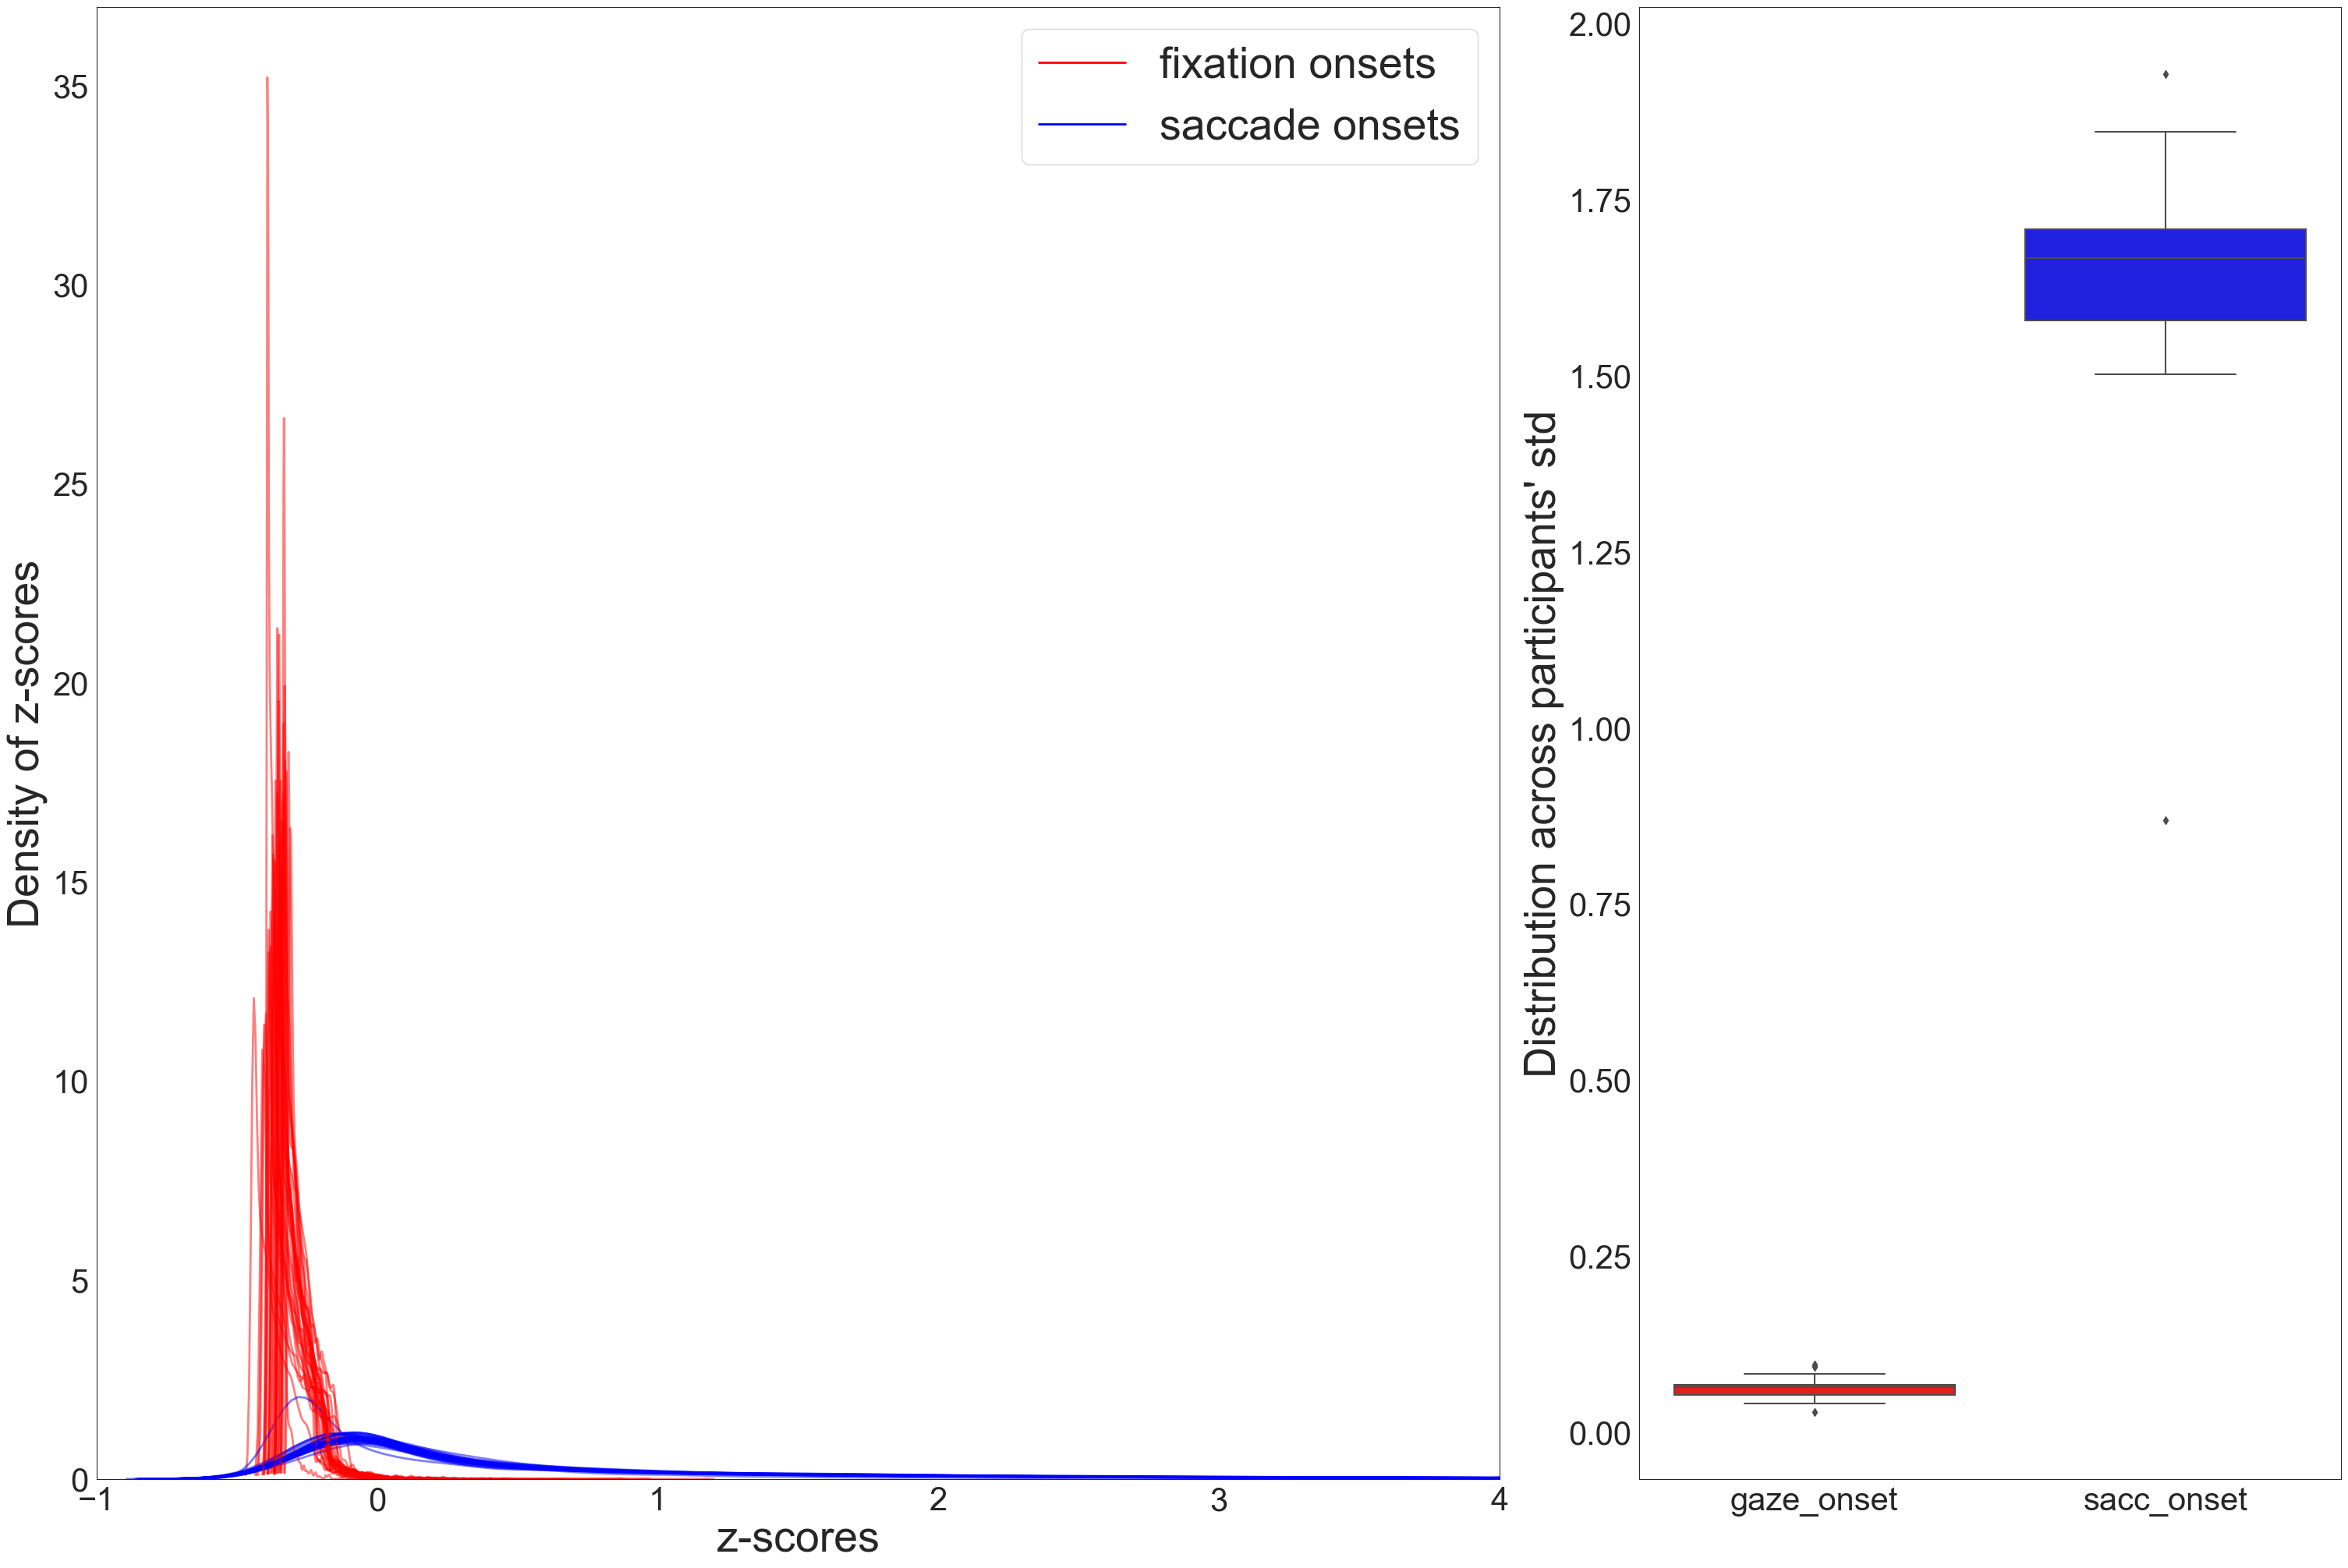

In [82]:
ids = recordings.index.tolist()
idd = ids[:]


# define:
labelsize = 40 # text
legendsize = 40 # ledgend
ticksize = 30 # ticks
numbersize = 60 # A, B etc.
fname = "Arial" # font name
plt.rcParams["font.family"] = fname
plt.figure(figsize=(30, 20), constrained_layout=True)
sns.set_style("white") 
# grid to have the subplots arranged nicely
ax1 = plt.subplot2grid(shape=(1,3), loc=(0, 0), rowspan=1, colspan=2)
ax2 = plt.subplot2grid(shape=(1,3), loc=(0, 2), rowspan=1, colspan=1)

data = {} # save data
for uid in idd:
    data[uid[:5]] = {}

    # load data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    for_eye['z_score'] = (for_eye['combined_vel'] - for_eye['combined_vel'].mean()) / for_eye['combined_vel'].std()

    # gaze onsets
    gaze_on = for_eye[(for_eye["events"] == 2.0)]
    gaze_on = gaze_on[~gaze_on["long_events"].isnull()]
    data[uid[:5]]["gaze_onset"] = np.std(gaze_on["z_score"])
    
    # saccade onsets
    sacc_on = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)]
    sacc_on.loc[:, "long_events"] = sacc_on["long_events"].shift(-1)    
    sacc_on = sacc_on[sacc_on["events"] == 1.0]
    sacc_on = sacc_on[~sacc_on["long_events"].isnull()]  
    data[uid[:5]]["sacc_onset"] = np.std(sacc_on["z_score"])

    
    sns.kdeplot(
        gaze_on["z_score"],
        bw_adjust=0.5,
        color="r",
        linewidth = 2,
        alpha = 0.5,
        ax = ax1,
        label="fixation onsets"
    )
    sns.kdeplot(
        sacc_on["z_score"],
        bw_adjust=0.5,
        color="b",
        linewidth = 2,
        alpha = 0.5,
        ax = ax1,
        label="saccade onsets"
    )
        

handles, labels = ax1.get_legend_handles_labels()
leg = ax1.legend([handles[0], handles[-1]],
                [labels[0], labels[-1]],
                loc="upper right", fontsize=legendsize)#
for lh in leg.legend_handles:
    lh.set_alpha(1)
# axis labels
ax1.set_xlabel("z-scores", fontsize=labelsize, fontname=fname)
ax1.set_ylabel("Density of z-scores", fontsize=labelsize, fontname=fname)
for label in ax1.get_xticklabels(): # change tick font
    label.set_fontproperties(fname)
for label in ax1.get_yticklabels():
    label.set_fontproperties(fname)
# ticks
ax1.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
ax1.xaxis.set_tick_params(labelsize=ticksize)
ax1.set_xlim(-1, 4)  # X-axis from 0 to 1400



data = pd.DataFrame(data).transpose()
palette=["red", "blue"]
sns.boxplot(data,ax=ax2, palette=palette)
plt.savefig("./images/compare_vel_dist_at_event_onset.png", bbox_inches="tight", pad_inches=0, dpi=400)
# axis labels
#ax1.set_xlabel("z-scores", fontsize=labelsize, fontname=fname)
ax2.set_ylabel("Distribution across participants' std", fontsize=labelsize, fontname=fname)
for label in ax2.get_xticklabels(): # change tick font
    label.set_fontproperties(fname)
for label in ax2.get_yticklabels():
    label.set_fontproperties(fname)
# ticks
ax2.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
ax2.xaxis.set_tick_params(labelsize=ticksize)

plt.savefig("./images/compare_vel_dist_at_event_onset.png", bbox_inches="tight", pad_inches=0, dpi=400)

plt.show()

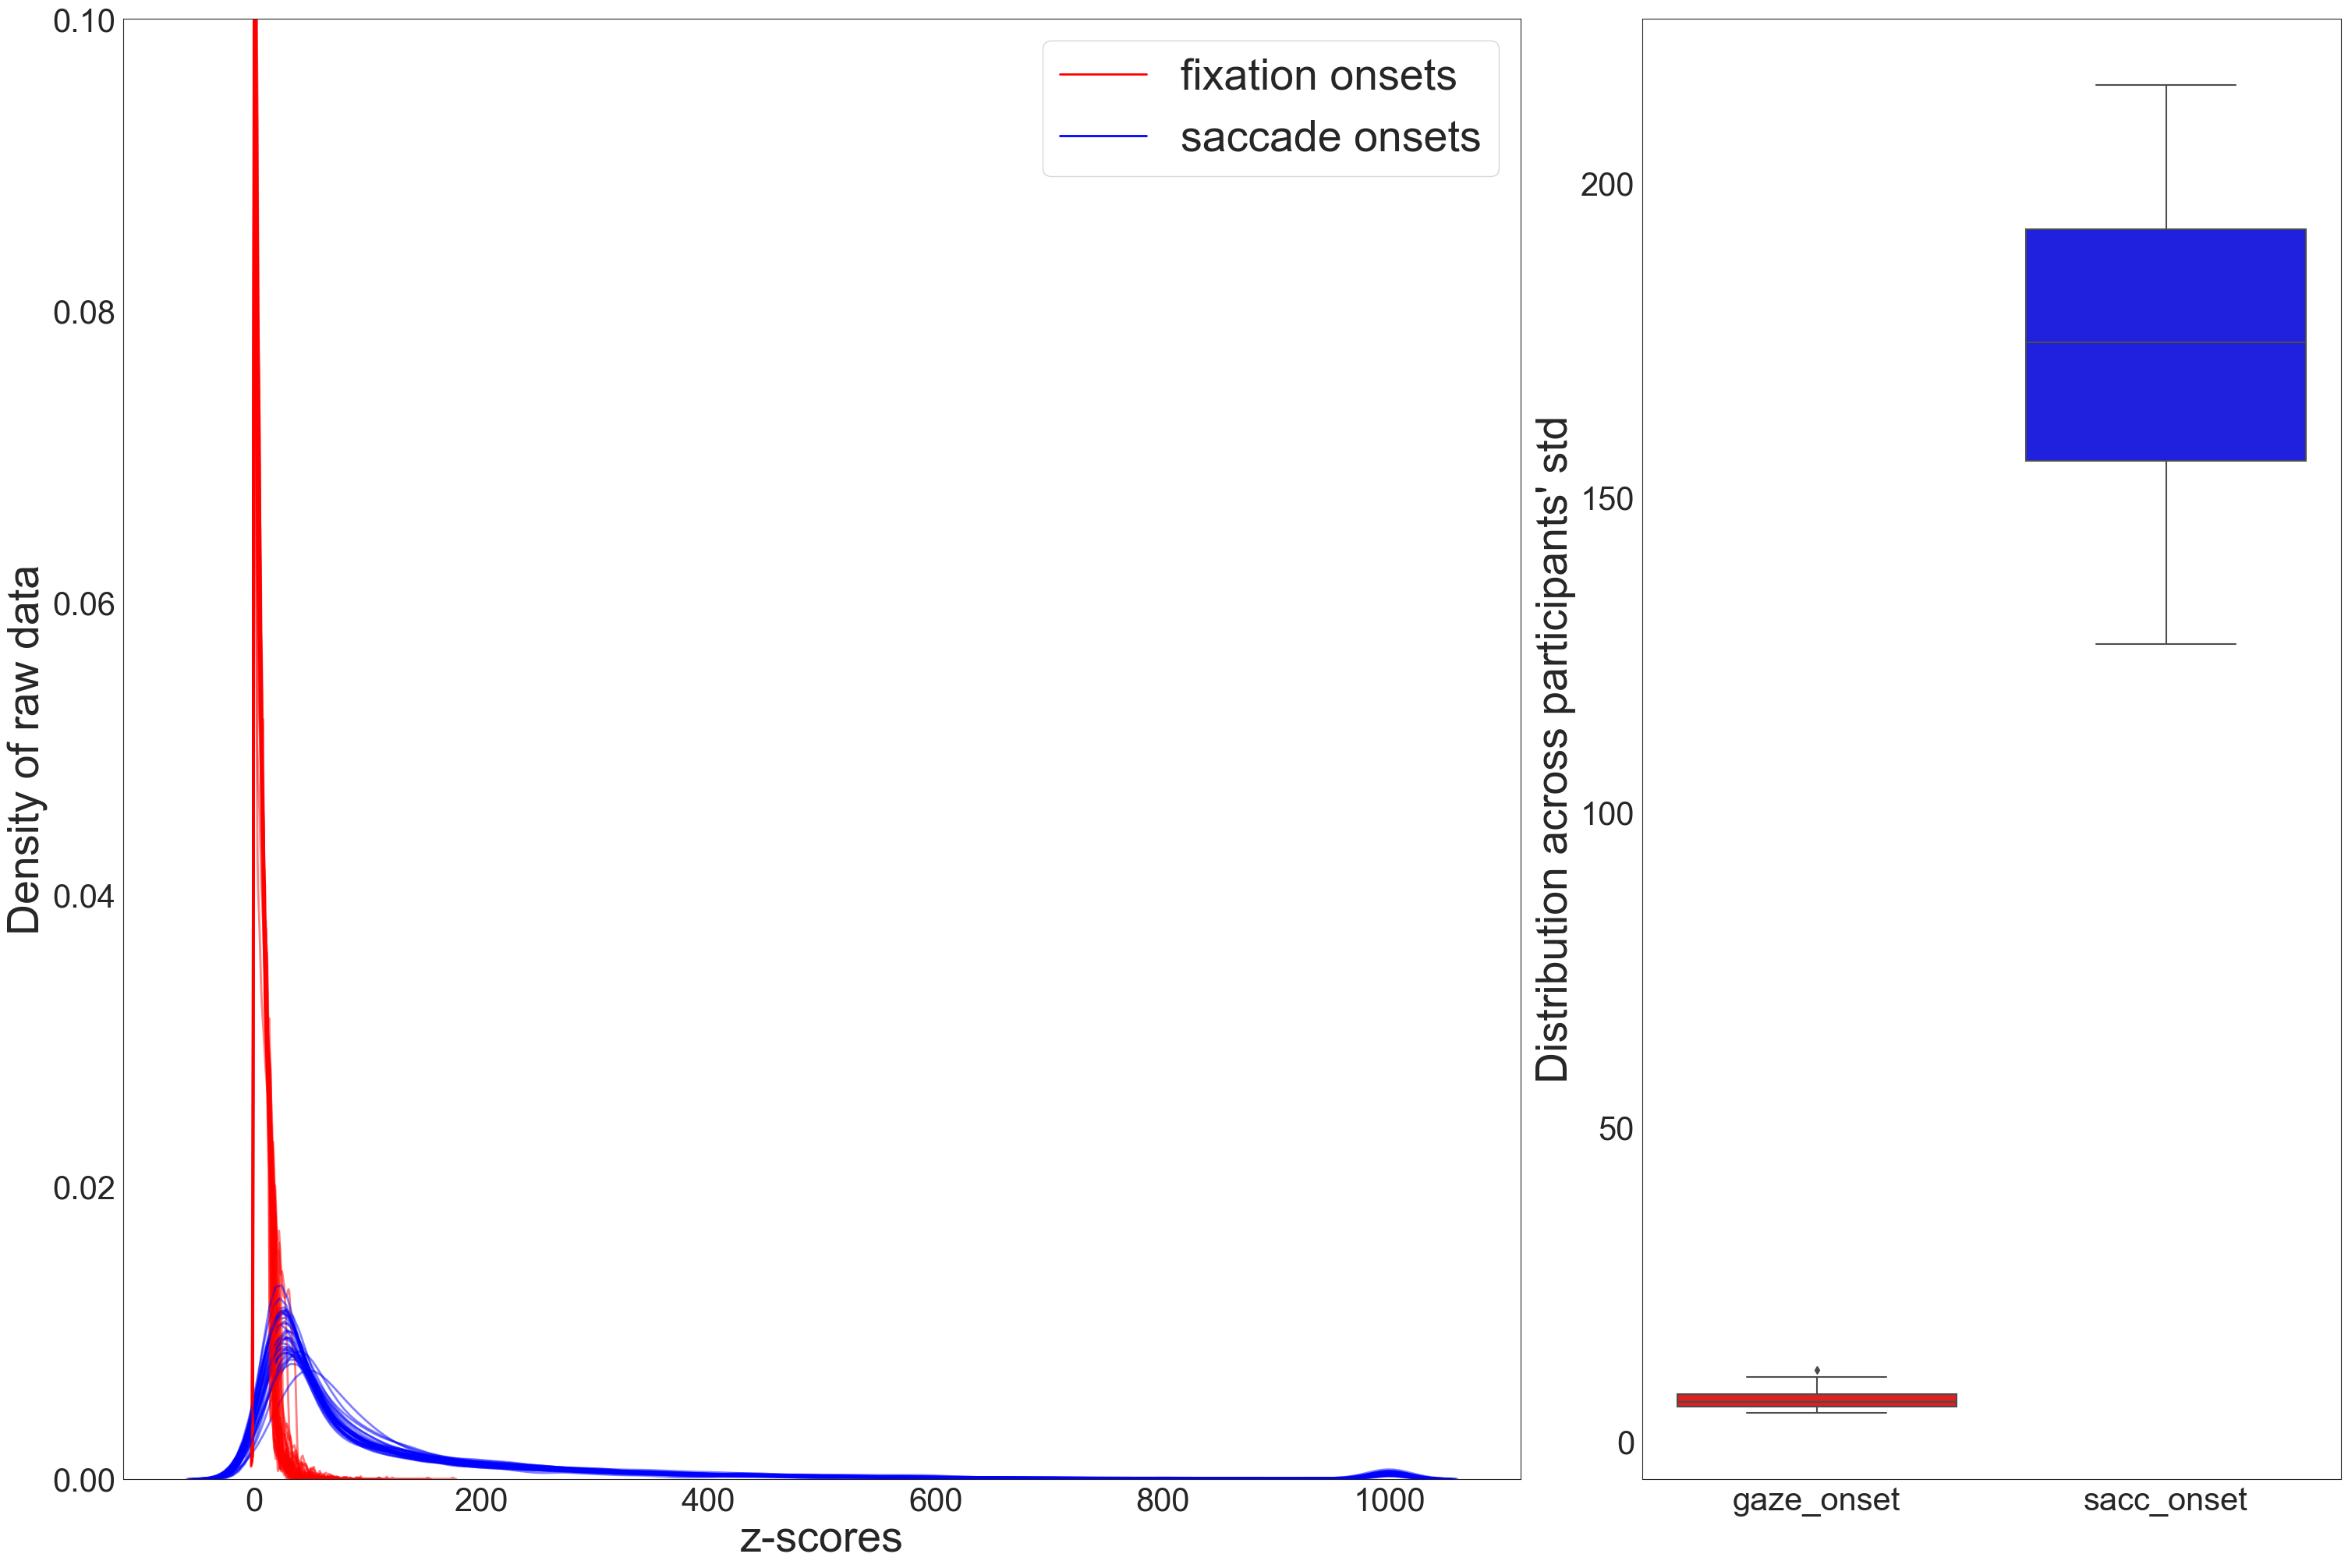

In [81]:
ids = recordings.index.tolist()
idd = ids[:]


# define:
labelsize = 40 # text
legendsize = 40 # ledgend
ticksize = 30 # ticks
numbersize = 60 # A, B etc.
fname = "Arial" # font name
plt.rcParams["font.family"] = fname
plt.figure(figsize=(30, 20), constrained_layout=True)
sns.set_style("white") 
# grid to have the subplots arranged nicely
ax1 = plt.subplot2grid(shape=(1,3), loc=(0, 0), rowspan=1, colspan=2)
ax2 = plt.subplot2grid(shape=(1,3), loc=(0, 2), rowspan=1, colspan=1)

data = {} # save data
for uid in idd:
    data[uid[:5]] = {}

    # load data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)

    # gaze onsets
    gaze_on = for_eye[(for_eye["events"] == 2.0)]
    gaze_on = gaze_on[~gaze_on["long_events"].isnull()]
    data[uid[:5]]["gaze_onset"] = np.std(gaze_on["combined_vel"])
    
    # saccade onsets
    sacc_on = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)]
    sacc_on.loc[:, "long_events"] = sacc_on["long_events"].shift(-1)    
    sacc_on = sacc_on[sacc_on["events"] == 1.0]
    sacc_on = sacc_on[~sacc_on["long_events"].isnull()]  
    data[uid[:5]]["sacc_onset"] = np.std(sacc_on["combined_vel"])

    
    sns.kdeplot(
        gaze_on["combined_vel"],
        bw_adjust=0.5,
        color="r",
        linewidth = 2,
        alpha = 0.5,
        ax = ax1,
        label="fixation onsets"
    )
    sns.kdeplot(
        sacc_on["combined_vel"],
        bw_adjust=0.5,
        color="b",
        linewidth = 2,
        alpha = 0.5,
        ax = ax1,
        label="saccade onsets"
    )
        

handles, labels = ax1.get_legend_handles_labels()
leg = ax1.legend([handles[0], handles[-1]],
                [labels[0], labels[-1]],
                loc="upper right", fontsize=legendsize)#
for lh in leg.legend_handles:
    lh.set_alpha(1)
# axis labels
ax1.set_xlabel("z-scores", fontsize=labelsize, fontname=fname)
ax1.set_ylabel("Density of raw data", fontsize=labelsize, fontname=fname)
for label in ax1.get_xticklabels(): # change tick font
    label.set_fontproperties(fname)
for label in ax1.get_yticklabels():
    label.set_fontproperties(fname)
# ticks
ax1.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
ax1.xaxis.set_tick_params(labelsize=ticksize)
ax1.set_ylim(0, 0.1)  # X-axis from 0 to 1400



data = pd.DataFrame(data).transpose()
palette=["red", "blue"]
sns.boxplot(data,ax=ax2, palette=palette)
plt.savefig("./images/compare_vel_dist_at_event_onset.png", bbox_inches="tight", pad_inches=0, dpi=400)
# axis labels
#ax1.set_xlabel("z-scores", fontsize=labelsize, fontname=fname)
ax2.set_ylabel("Distribution across participants' std", fontsize=labelsize, fontname=fname)
for label in ax2.get_xticklabels(): # change tick font
    label.set_fontproperties(fname)
for label in ax2.get_yticklabels():
    label.set_fontproperties(fname)
# ticks
ax2.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
ax2.xaxis.set_tick_params(labelsize=ticksize)

plt.savefig("./images/compare_vel_dist_at_event_onset_raw.png", bbox_inches="tight", pad_inches=0, dpi=400)

plt.show()

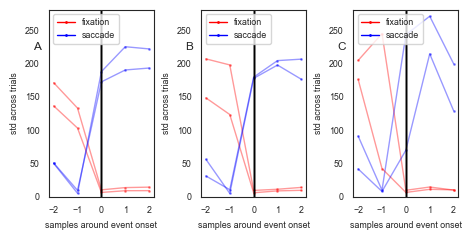

In [137]:
# Now lets look at the distribution over time

ids = recordings.index.tolist()
idd = ids[:2]

start_fr = 2  # how many frames before gaze onset
end_fr = 3  # how many frames to include gaze onset and after


# define:
new_height_cm = 6.39  # 1 column = 3.09; 1.5 columns = 4.22; 2 columns = 6.39
original_height_cm = 12 # adjust
original_fontsize = 40
# define
numbersize = 80 * (new_height_cm/60)# A, B etc.
labelsize = 40  * (new_height_cm/40)#text
legendsize = 40  * (new_height_cm/40)#ledgend
ticksize = 30  * (new_height_cm/30)#ticks
fname = "Arial" # font name

# set figure size
fig_width_cm = 11.6  # 1 column = 8.5; 1.5 columns = 11.6; 2 columns = 17.6
fig_width_in = fig_width_cm / 2.54
aspect_ratio = 20/40
fig_height_in = fig_width_in * aspect_ratio
#plt.figure(figsize=(30, 30), constrained_layout=True)
plt.figure(figsize=(fig_width_in, fig_height_in), constrained_layout=True)
# grid to have the subplots arranged nicely
ax1 = plt.subplot2grid(shape=(1,3), loc=(0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(shape=(1,3), loc=(0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid(shape=(1,3), loc=(0, 2), rowspan=1, colspan=1)
'''
ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')
ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')
ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')
'''
for uid in idd:

    # load data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)

    # gaze onsets
    gaze_on = for_eye[(for_eye["events"] == 2.0)]
    gaze_on = gaze_on[~gaze_on["long_events"].isnull()]
    gaze_on = gaze_on[~gaze_on["names"].isnull()]
    
    # saccade onsets
    sacc_on = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)]
    sacc_on.loc[:, "long_events"] = sacc_on["long_events"].shift(-1)   
    sacc_on.loc[:, "names"] = sacc_on["names"].shift(-1)   
    sacc_on = sacc_on[sacc_on["events"] == 1.0]
    sacc_on = sacc_on[~sacc_on["long_events"].isnull()]  
    sacc_on = sacc_on[~sacc_on["names"].isnull()]

    
    trials_gaze_bgrd = {}
    trials_gaze_body = {}
    trials_gaze_head = {}
    trials_sacc_bgrd = {}
    trials_sacc_body = {}
    trials_sacc_head = {}
    for g, (gz, sz) in enumerate(zip(gaze_on.index, sacc_on.index)):
        # only use trials that have datapoints for all frames needed
        if (gz - start_fr) > 0 and (gz + end_fr) < len(for_eye) and (sz - start_fr) > 0 and (sz + end_fr) < len(for_eye):
            # get the current segment
            cur_gaze = for_eye.iloc[gz - start_fr : gz + end_fr]
            cur_sacc = for_eye.iloc[sz - start_fr : sz + end_fr]
            
            # Add segments to trial DataFrames
            name = gaze_on.loc[gz, "names"]
            if "NPC" not in name and "face" not in name:
                trials_gaze_bgrd[g] = cur_gaze["combined_vel"].tolist()
                trials_sacc_bgrd[g] = cur_sacc["combined_vel"].tolist()
            elif "NPC" in name:
                trials_gaze_body[g] = cur_gaze["combined_vel"].tolist()
                trials_sacc_body[g] = cur_sacc["combined_vel"].tolist()
            elif "face" in name:
                trials_gaze_head[g] = cur_gaze["combined_vel"].tolist()
                trials_sacc_head[g] = cur_sacc["combined_vel"].tolist()
            
    trials_gaze_bgrd = pd.DataFrame(trials_gaze_bgrd).transpose()
    trials_gaze_body = pd.DataFrame(trials_gaze_body).transpose()
    trials_gaze_head = pd.DataFrame(trials_gaze_head).transpose()
    trials_sacc_bgrd = pd.DataFrame(trials_sacc_bgrd).transpose()
    trials_sacc_body = pd.DataFrame(trials_sacc_body).transpose()
    trials_sacc_head = pd.DataFrame(trials_sacc_head).transpose()
    # plot this result:
    # bgrd
    
    ax1.plot(list(range(-start_fr,end_fr)), trials_gaze_bgrd.std(skipna=True), color="r", 
                linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="fixation")
    ax1.plot(list(range(-start_fr,end_fr)), trials_sacc_bgrd.std(skipna=True), color="b", 
                linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="saccade")
    # body
    ax2.plot(list(range(-start_fr,end_fr)), trials_gaze_body.std(skipna=True), color="r", 
                linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="fixation")
    ax2.plot(list(range(-start_fr,end_fr)), trials_sacc_body.std(skipna=True), color="b", 
                linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="saccade")
    # head
    ax3.plot(list(range(-start_fr,end_fr)), trials_gaze_head.std(skipna=True), color="r", 
                linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="fixation")
    ax3.plot(list(range(-start_fr,end_fr)), trials_sacc_head.std(skipna=True), color="b", 
                linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="saccade")

axis = [ax1,ax2,ax3]
for ax in axis:
    ax.axvline(x=0, linewidth=1, color="k")
    ax.axvline(x=0, linewidth=1, color="k")
    ax.axvline(x=0, linewidth=1, color="k")

    
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend([handles[0], handles[-1]],
                    [labels[0], labels[-1]],
                    loc="upper left", fontsize=legendsize)#
    for lh in leg.legend_handles:
        lh.set_alpha(1)
        
    
    # axis labels
    ax.set_ylabel("std across trials", fontsize=labelsize, fontname=fname)
    ax.set_xlabel("samples around event onset", fontsize=labelsize, fontname=fname)
    for label in ax.get_xticklabels(): # change tick font
        label.set_fontproperties(fname)
    for label in ax.get_yticklabels():
        label.set_fontproperties(fname)
        
    # ticks
    ax.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
    ax.xaxis.set_tick_params(labelsize=ticksize)
    ax.set_xticks([-2,-1,0,1,2],)
    ax.set_ylim(0, 280)   # Y-axis from 0 to 600

ax1.set_title("A", fontsize=numbersize, fontweight="bold",loc="left", x=-0.15, y=1.01, pad=-30, fontname=fname) 
ax2.set_title("B", fontsize=numbersize, fontweight="bold",loc="left", x=-0.15, y=1.01, pad=-30, fontname=fname) 
ax3.set_title("C", fontsize=numbersize, fontweight="bold",loc="left", x=-0.15, y=1.01, pad=-30, fontname=fname) 

plt.savefig("./images/vel_dist_over_time_diffCond_std.png", bbox_inches="tight", pad_inches=0, dpi=400)

plt.show()

# Figure 3_new: Event Onsets

In [143]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

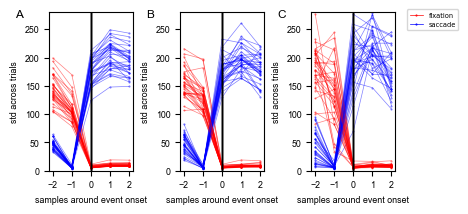

In [35]:
# Now lets look at the distribution over time

ids = recordings.index.tolist()
idd = ids[:]

start_fr = 2  # how many frames before gaze onset
end_fr = 3  # how many frames to include gaze onset and after


# define:
new_height_cm = 6.39  # 1 column = 3.09; 1.5 columns = 4.22; 2 columns = 6.39
original_height_cm = 12 # adjust
original_fontsize = 40
# define
numbersize = 80 * (new_height_cm/60)# A, B etc.
labelsize = 40  * (new_height_cm/40)#text
legendsize = 30  * (new_height_cm/40)#ledgend
ticksize = 30  * (new_height_cm/30)#ticks
fname = "Arial" # font name

# set figure size
fig_width_cm = 11.6  # 1 column = 8.5; 1.5 columns = 11.6; 2 columns = 17.6
fig_width_in = fig_width_cm / 2.54
aspect_ratio = 20/45
fig_height_in = fig_width_in * aspect_ratio
#plt.figure(figsize=(30, 30), constrained_layout=True)
plt.figure(figsize=(fig_width_in, fig_height_in), constrained_layout=True)
# grid to have the subplots arranged nicely
ax1 = plt.subplot2grid(shape=(1,3), loc=(0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(shape=(1,3), loc=(0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid(shape=(1,3), loc=(0, 2), rowspan=1, colspan=1)
'''
ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')
ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')
ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')
'''
for uid in idd:

    # load data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)

    # gaze onsets
    gaze_on = for_eye[(for_eye["events"] == 2.0)]
    gaze_on = gaze_on[~gaze_on["long_events"].isnull()]
    gaze_on = gaze_on[~gaze_on["names"].isnull()]
    
    # saccade onsets
    sacc_on = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)]
    sacc_on.loc[:, "long_events"] = sacc_on["long_events"].shift(-1)   
    sacc_on.loc[:, "names"] = sacc_on["names"].shift(-1)   
    sacc_on = sacc_on[sacc_on["events"] == 1.0]
    sacc_on = sacc_on[~sacc_on["long_events"].isnull()]  
    sacc_on = sacc_on[~sacc_on["names"].isnull()]

    
    trials_gaze_bgrd = {}
    trials_gaze_body = {}
    trials_gaze_head = {}
    trials_sacc_bgrd = {}
    trials_sacc_body = {}
    trials_sacc_head = {}
    for g, (gz, sz) in enumerate(zip(gaze_on.index, sacc_on.index)):
        # only use trials that have datapoints for all frames needed
        if (gz - start_fr) > 0 and (gz + end_fr) < len(for_eye) and (sz - start_fr) > 0 and (sz + end_fr) < len(for_eye):
            # get the current segment
            cur_gaze = for_eye.iloc[gz - start_fr : gz + end_fr]
            cur_sacc = for_eye.iloc[sz - start_fr : sz + end_fr]
            
            # Add segments to trial DataFrames
            name = gaze_on.loc[gz, "names"]
            if "NPC" not in name and "face" not in name:
                trials_gaze_bgrd[g] = cur_gaze["combined_vel"].tolist()
                trials_sacc_bgrd[g] = cur_sacc["combined_vel"].tolist()
            elif "NPC" in name:
                trials_gaze_body[g] = cur_gaze["combined_vel"].tolist()
                trials_sacc_body[g] = cur_sacc["combined_vel"].tolist()
            elif "face" in name:
                trials_gaze_head[g] = cur_gaze["combined_vel"].tolist()
                trials_sacc_head[g] = cur_sacc["combined_vel"].tolist()
            
    trials_gaze_bgrd = pd.DataFrame(trials_gaze_bgrd).transpose()
    trials_gaze_body = pd.DataFrame(trials_gaze_body).transpose()
    trials_gaze_head = pd.DataFrame(trials_gaze_head).transpose()
    trials_sacc_bgrd = pd.DataFrame(trials_sacc_bgrd).transpose()
    trials_sacc_body = pd.DataFrame(trials_sacc_body).transpose()
    trials_sacc_head = pd.DataFrame(trials_sacc_head).transpose()
    # plot this result:
    # bgrd
    
    ax1.plot(list(range(-start_fr,end_fr)), trials_gaze_bgrd.std(skipna=True), color="r", 
                linestyle='solid',marker='o',linewidth=0.5, markersize=0.5, alpha=0.5, label="fixation")
    ax1.plot(list(range(-start_fr,end_fr)), trials_sacc_bgrd.std(skipna=True), color="b", 
                linestyle='solid',marker='o',linewidth=0.5, markersize=0.5, alpha=0.5, label="saccade")
    # body
    ax2.plot(list(range(-start_fr,end_fr)), trials_gaze_body.std(skipna=True), color="r", 
                linestyle='solid',marker='o',linewidth=0.5, markersize=0.5, alpha=0.5, label="fixation")
    ax2.plot(list(range(-start_fr,end_fr)), trials_sacc_body.std(skipna=True), color="b", 
                linestyle='solid',marker='o',linewidth=0.5, markersize=0.5, alpha=0.5, label="saccade")
    # head
    ax3.plot(list(range(-start_fr,end_fr)), trials_gaze_head.std(skipna=True), color="r", 
                linestyle='solid',marker='o',linewidth=0.5, markersize=0.5, alpha=0.5, label="fixation")
    ax3.plot(list(range(-start_fr,end_fr)), trials_sacc_head.std(skipna=True), color="b", 
                linestyle='solid',marker='o',linewidth=0.5, markersize=0.5, alpha=0.5, label="saccade")

axis = [ax1,ax2,ax3]
for ax in axis:
    ax.axvline(x=0, linewidth=1, color="k")
    ax.axvline(x=0, linewidth=1, color="k")
    ax.axvline(x=0, linewidth=1, color="k")
        
    # axis labels
    ax.set_ylabel("std across trials", fontsize=labelsize, fontname=fname)
    ax.set_xlabel("samples around event onset", fontsize=labelsize, fontname=fname)
    for label in ax.get_xticklabels(): # change tick font
        label.set_fontproperties(fname)
    for label in ax.get_yticklabels():
        label.set_fontproperties(fname)
        
    # ticks
    ax.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
    ax.xaxis.set_tick_params(labelsize=ticksize)
    ax.set_xticks([-2,-1,0,1,2],)
    ax.set_ylim(0, 280)   # Y-axis from 0 to 600

handles, labels = ax3.get_legend_handles_labels()
leg = ax3.legend([handles[0], handles[-1]],
                [labels[0], labels[-1]],
                loc="upper left", fontsize=legendsize,bbox_to_anchor=(1.1, 1.04))#
for lh in leg.legend_handles:
    lh.set_alpha(1)

ax1.set_title("A", fontsize=numbersize, fontweight="bold",loc="left", x=-0.4, y=1.23, pad=-30, fontname=fname) 
ax2.set_title("B", fontsize=numbersize, fontweight="bold",loc="left", x=-0.4, y=1.23, pad=-30, fontname=fname) 
ax3.set_title("C", fontsize=numbersize, fontweight="bold",loc="left", x=-0.4, y=1.23, pad=-30, fontname=fname) 

plt.savefig("./images/fig_for_submission/Figure3NEW.png", bbox_inches="tight", pad_inches=0, dpi=400)

plt.show()

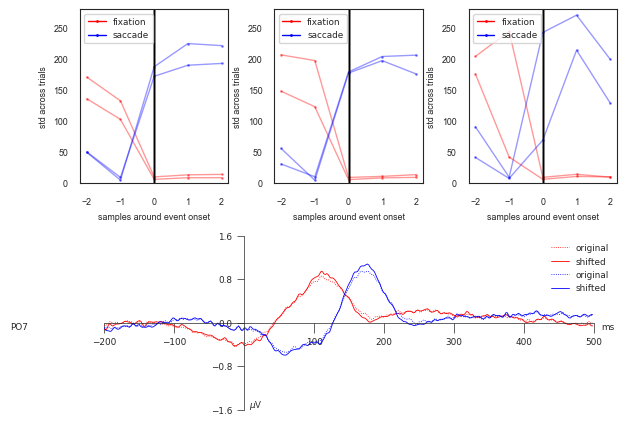

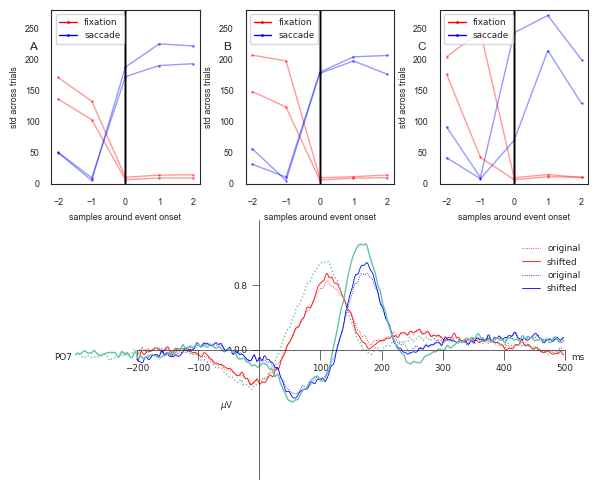

In [30]:
# Now lets look at the distribution over time

ids = recordings.index.tolist()
idd = ids[:2]

start_fr = 2  # how many frames before gaze onset
end_fr = 3  # how many frames to include gaze onset and after


# define:
new_height_cm = 6.39  # 1 column = 3.09; 1.5 columns = 4.22; 2 columns = 6.39
original_height_cm = 12 # adjust
original_fontsize = 40
# define
numbersize = 80 * (new_height_cm/60)# A, B etc.
labelsize = 40  * (new_height_cm/40)#text
legendsize = 40  * (new_height_cm/40)#ledgend
ticksize = 30  * (new_height_cm/30)#ticks
fname = "Arial" # font name

# set figure size
fig_width_cm = 17.6  # 1 column = 8.5; 1.5 columns = 11.6; 2 columns = 17.6
fig_width_in = fig_width_cm / 2.54
aspect_ratio = 30/40
fig_height_in = fig_width_in * aspect_ratio
#plt.figure(figsize=(30, 30), constrained_layout=True)
#plt.figure(figsize=(fig_width_in, fig_height_in), constrained_layout=True)
rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
      "xtick.major.size" : fig_width_in, "ytick.major.size" : fig_height_in,
      "xtick.major.width" : 0.5, "ytick.major.width" : 0.5,
     "figure.figsize": (fig_width_in, fig_height_in)}
with plt.rc_context(rc):
    plt.figure()
    sns.set_style("white") 
    plt.subplots_adjust(wspace=0.9, hspace=0.3)

    # grid to have the subplots arranged nicely
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0, 0), rowspan=1, colspan=2)
    ax2 = plt.subplot2grid(shape=(2,6), loc=(0, 2), rowspan=1, colspan=2)
    ax3 = plt.subplot2grid(shape=(2,6), loc=(0, 4), rowspan=1, colspan=2)
    ax4 = plt.subplot2grid(shape=(2,6), loc=(1, 0), rowspan=1, colspan=6)
    '''
    ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')
    ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')
    ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')
    '''
    for uid in idd:
    
        # load data
        for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    
        # gaze onsets
        gaze_on = for_eye[(for_eye["events"] == 2.0)]
        gaze_on = gaze_on[~gaze_on["long_events"].isnull()]
        gaze_on = gaze_on[~gaze_on["names"].isnull()]
        
        # saccade onsets
        sacc_on = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)]
        sacc_on.loc[:, "long_events"] = sacc_on["long_events"].shift(-1)   
        sacc_on.loc[:, "names"] = sacc_on["names"].shift(-1)   
        sacc_on = sacc_on[sacc_on["events"] == 1.0]
        sacc_on = sacc_on[~sacc_on["long_events"].isnull()]  
        sacc_on = sacc_on[~sacc_on["names"].isnull()]
    
        
        trials_gaze_bgrd = {}
        trials_gaze_body = {}
        trials_gaze_head = {}
        trials_sacc_bgrd = {}
        trials_sacc_body = {}
        trials_sacc_head = {}
        for g, (gz, sz) in enumerate(zip(gaze_on.index, sacc_on.index)):
            # only use trials that have datapoints for all frames needed
            if (gz - start_fr) > 0 and (gz + end_fr) < len(for_eye) and (sz - start_fr) > 0 and (sz + end_fr) < len(for_eye):
                # get the current segment
                cur_gaze = for_eye.iloc[gz - start_fr : gz + end_fr]
                cur_sacc = for_eye.iloc[sz - start_fr : sz + end_fr]
                
                # Add segments to trial DataFrames
                name = gaze_on.loc[gz, "names"]
                if "NPC" not in name and "face" not in name:
                    trials_gaze_bgrd[g] = cur_gaze["combined_vel"].tolist()
                    trials_sacc_bgrd[g] = cur_sacc["combined_vel"].tolist()
                elif "NPC" in name:
                    trials_gaze_body[g] = cur_gaze["combined_vel"].tolist()
                    trials_sacc_body[g] = cur_sacc["combined_vel"].tolist()
                elif "face" in name:
                    trials_gaze_head[g] = cur_gaze["combined_vel"].tolist()
                    trials_sacc_head[g] = cur_sacc["combined_vel"].tolist()
                
        trials_gaze_bgrd = pd.DataFrame(trials_gaze_bgrd).transpose()
        trials_gaze_body = pd.DataFrame(trials_gaze_body).transpose()
        trials_gaze_head = pd.DataFrame(trials_gaze_head).transpose()
        trials_sacc_bgrd = pd.DataFrame(trials_sacc_bgrd).transpose()
        trials_sacc_body = pd.DataFrame(trials_sacc_body).transpose()
        trials_sacc_head = pd.DataFrame(trials_sacc_head).transpose()
        # plot this result:
        # bgrd
        
        ax1.plot(list(range(-start_fr,end_fr)), trials_gaze_bgrd.std(skipna=True), color="r", 
                    linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="fixation")
        ax1.plot(list(range(-start_fr,end_fr)), trials_sacc_bgrd.std(skipna=True), color="b", 
                    linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="saccade")
        # body
        ax2.plot(list(range(-start_fr,end_fr)), trials_gaze_body.std(skipna=True), color="r", 
                    linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="fixation")
        ax2.plot(list(range(-start_fr,end_fr)), trials_sacc_body.std(skipna=True), color="b", 
                    linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="saccade")
        # head
        ax3.plot(list(range(-start_fr,end_fr)), trials_gaze_head.std(skipna=True), color="r", 
                    linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="fixation")
        ax3.plot(list(range(-start_fr,end_fr)), trials_sacc_head.std(skipna=True), color="b", 
                    linestyle='solid',marker='o',linewidth=1, markersize=1, alpha=0.4, label="saccade")
    
    axis = [ax1,ax2,ax3]
    for ax in axis:
        ax.axvline(x=0, linewidth=1, color="k")
        ax.axvline(x=0, linewidth=1, color="k")
        ax.axvline(x=0, linewidth=1, color="k")
    
        
        handles, labels = ax.get_legend_handles_labels()
        leg = ax.legend([handles[0], handles[-1]],
                        [labels[0], labels[-1]],
                        loc="upper left", fontsize=legendsize)#
        for lh in leg.legend_handles:
            lh.set_alpha(1)
            
        
        # axis labels
        ax.set_ylabel("std across trials", fontsize=labelsize, fontname=fname)
        ax.set_xlabel("samples around event onset", fontsize=labelsize, fontname=fname)
        for label in ax.get_xticklabels(): # change tick font
            label.set_fontproperties(fname)
        for label in ax.get_yticklabels():
            label.set_fontproperties(fname)
            
        # ticks
        ax.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
        ax.xaxis.set_tick_params(labelsize=ticksize)
        ax.set_xticks([-2,-1,0,1,2],)
        ax.set_ylim(0, 280)   # Y-axis from 0 to 600
    
    
    ##### Plotting shifted ERP #####
    mat = scipy.io.loadmat(f"{PATH_EEG}/Shifted_and_orig_ERPs_Sacc.mat")
    avg_sacc_trials_origi = pd.DataFrame(mat['avg_sacc_trials_origi'])
    avg_sacc_trials_shift = pd.DataFrame(mat['avg_sacc_trials_shift'])
    times = mat['times'][0].tolist()
    
    mat = scipy.io.loadmat(f"{PATH_EEG}/Shifted_and_orig_ERPs_Gaze.mat")
    avg_gaze_trials_origi = pd.DataFrame(mat['avg_gaze_trials_origi'])
    avg_gaze_trials_shift = pd.DataFrame(mat['avg_gaze_trials_shift'])

    ax4.plot(times,avg_gaze_trials_origi.mean(axis=0).tolist(),color='r',linewidth=0.6,alpha=1,linestyle=':',label="original")
    ax4.plot(times,avg_gaze_trials_shift.mean(axis=0).tolist(),color='r',linewidth=0.6,alpha=1,linestyle='-',label="shifted")
    ax4.plot(times,avg_sacc_trials_origi.mean(axis=0).tolist(),color='b',linewidth=0.6,alpha=1,linestyle=':',label="original")
    ax4.plot(times,avg_sacc_trials_shift.mean(axis=0).tolist(),color='b',linewidth=0.6,alpha=1,linestyle='-',label="shifted")

    # legend:
    handles, labels = ax4.get_legend_handles_labels()
    legend = ax4.legend(handles,labels,loc="upper right", fontsize=ticksize, frameon=False)
    # axis labels
    ax4.set_ylabel(u'$\it{\u03bc}$' + 'V', fontsize=labelsize, fontname=fname, loc='bottom', rotation = 0)
    ax4.yaxis.set_label_coords(0.315,-0.009)
    ax4.text(-335,-0.12,"PO7", fontsize=labelsize)
    ax4.text(510,-0.12,"ms", fontsize=labelsize)
    # ticks
    x = [-200,-100,100,200,300,400,500]
    ax4.set_xticks(x)
    #y = [-4,-3,-2,-1,0,1,2,3,4]
    y = [-1.6,-0.8,0,0.8,1.6]
    ax4.set_yticks(y)
    for label in ax4.get_xticklabels(): # change tick font
        label.set_fontproperties(fname)
    for label in ax4.get_yticklabels():
        label.set_fontproperties(fname)
    ax4.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
    ax4.xaxis.set_tick_params(labelsize=ticksize)
    # adjust spines
    ax4.spines[['top','right']].set_visible(False)
    ax4.spines[['bottom','left']].set_linewidth(0.5)
    ax4.spines[['bottom','left']].set_position(('data', 0))
    ax4.spines[['bottom','left']].set_clip_on(True)
    ax4.spines[['left']].set_bounds([-1.6,1.6])
    ax4.spines[['bottom']].set_bounds([- 200,500])
    ax4.xaxis.set_ticks_position('bottom')
    ax4.yaxis.set_ticks_position('left')





    chan = 'PO7'
    chanlocs = scipy.io.loadmat(f"/net/store/nbp/projects/wd_ride_village/Analysis/FacePaper/ERPs_without_Unfold/TFCE_resources/chanLocs.mat")
    chanlocs = chanlocs['chanLocs']
    chanlocs = np.array([item[0][:] for item in chanlocs['labels'][0]]).tolist()
    chanidx = chanlocs.index(chan) # index
    
    
    mat = scipy.io.loadmat(f"{PATH_EEG}/FacePaper_ERPData_Full.mat") # change this with a file just for that subject
    gaze_bgrd = pd.DataFrame(mat['gaze_bgrd'][chanidx,:,:]).transpose()
    sacc_bgrd = pd.DataFrame(mat['sacc_bgrd'][chanidx,:,:]).transpose()
    time = mat['times'][0].tolist()

    
    ax4.plot(time,np.nanmean(gaze_bgrd,axis=0).tolist(),color=bgrd_color,linewidth=1,alpha=1,linestyle=':',label="bgrd fixation")

    ax4.plot(time,np.nanmean(sacc_bgrd,axis=0).tolist(),color=bgrd_color,linewidth=1,alpha=1,label="bgrd saccade")
    



ax1.set_title("A", fontsize=numbersize, fontweight="bold",loc="left", x=-0.15, y=1.01, pad=-30, fontname=fname) 
ax2.set_title("B", fontsize=numbersize, fontweight="bold",loc="left", x=-0.15, y=1.01, pad=-30, fontname=fname) 
ax3.set_title("C", fontsize=numbersize, fontweight="bold",loc="left", x=-0.15, y=1.01, pad=-30, fontname=fname) 

plt.savefig("./images/vel_dist_over_time_diffCond_std.png", bbox_inches="tight", pad_inches=0, dpi=400)

plt.show()

# Figure 3: Single Subject Results

ValueError: Length of values (12827) does not match length of index (4717)

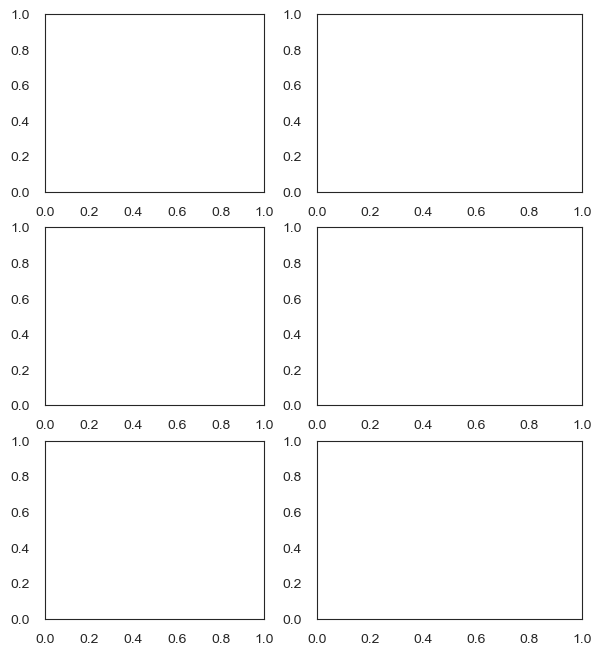

In [5]:
# set figure size
fig_width_cm = 17.6  # 1 column = 8.5; 1.5 columns = 11.6; 2 columns = 17.6
fig_width_in = fig_width_cm / 2.54
aspect_ratio = 34/30
fig_height_in = fig_width_in * aspect_ratio
# set up figure
# set up figure
rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
      "xtick.major.size" : fig_width_in, "ytick.major.size" : fig_height_in,
      "xtick.major.width" : 0.5, "ytick.major.width" : 0.5,
     "figure.figsize": (fig_width_in, fig_height_in)}
with plt.rc_context(rc):
    plt.figure()
    plt.tight_layout()  # Adjust subplot spacing dynamically
    sns.set_style("white") 

     # set fontsize: 
    new_height_cm = 7.39  # 1 column = 3.09; 1.5 columns = 4.22; 2 columns = 6.39
    original_height_cm = 30 # adjust
    # define
    numbersize = 80 * (new_height_cm/60)# A, B etc.
    labelsize = 30 * (new_height_cm/40)# text
    legendsize = 30 * (new_height_cm/40)# ledgend
    ticksize = 25 * (new_height_cm/30)# ticks
    fname = "Arial" # font name
    plt.rcParams["font.family"] = fname
    # set up grid
    siz = 12
    ax0 = plt.subplot2grid(shape=(3,siz), loc=(0, 0), rowspan=1, colspan=5)  
    ax1 = plt.subplot2grid(shape=(3,siz), loc=(1, 0), rowspan=1, colspan=5)    
    ax2 = plt.subplot2grid(shape=(3,siz), loc=(2, 0), rowspan=1, colspan=5)
    ax3 = plt.subplot2grid(shape=(3,siz), loc=(0, 6), rowspan=1, colspan=6)
    ax4 = plt.subplot2grid(shape=(3,siz), loc=(1, 6), rowspan=1, colspan=6)
    ax5 = plt.subplot2grid(shape=(3,siz), loc=(2, 6), rowspan=1, colspan=6)
    
    
    ###### Plot the Heatmap ######
    subj = [42,32,34,]
    axis = [ax0,ax1,ax2]
    axisERP = [ax3,ax4,ax5]
    for s,sub in enumerate(subj):
        mat = scipy.io.loadmat(f"{PATH_EEG}/Sub{sub}_trialOrderSaccAmpCorr.mat")
        data = pd.DataFrame(mat['data']).transpose()
        event_data = mat['event']
        # Extract fields
        saccade_dur = np.array([item[0][0] if item.size > 0 else None for item in event_data['saccade_dur'][0]])  # Handle empty arrays
        saccade_onset = np.array([item[0][0] if item.size > 0 else None for item in event_data['saccade_onset'][0]])  # Handle empty arrays
        # Create DataFrame
        events = pd.DataFrame({
            'saccade_dur': saccade_dur,
            'saccade_onset': saccade_onset
        })
         # add saccade onset & saccade duration
        data['saccade_onset'] = events.saccade_onset.tolist()
        data['saccade_dur'] = events.saccade_dur.tolist()
        # add saccade onset & saccade duration
        data['saccade_onset'] = events.saccade_onset.tolist()
        data['saccade_dur'] = events.saccade_dur.tolist()
        # sort data according to saccade duration
        data = data.sort_values('saccade_dur', ascending=False)
        data = data.reset_index(drop=True) # reset index
        data = data.drop(columns=['saccade_dur']) # remove saccade duration, we don't need it anymore
        saccade_onset = data['saccade_onset'].tolist() # save saccade_onsets separately
        data = data.drop(columns=['saccade_onset']) # remove column
        # smooth the data (for plotting)
        data = data.apply(lambda x: gaussian_filter1d(x, sigma=2), axis=0)
        data = pd.DataFrame(data).transpose()
        data = data.apply(lambda x: gaussian_filter1d(x, sigma=5), axis=0)
        data = pd.DataFrame(data).transpose()
        data = data.to_numpy()

        # plot the data
        
        sns.heatmap(data, cmap="RdBu_r",cbar=False, xticklabels=100, yticklabels=1000, ax=axis[s], vmin=-10, vmax=10,)  
        time = np.array(mat['times'][0].tolist())
        for i, highlight_value in enumerate(saccade_onset):
            closest_col = np.argmin(np.abs(time - highlight_value))
            # Plot a black marker at that position
            if closest_col != 0:
                axis[s].plot(closest_col + 0.1, i + 0.1, 'ko',markersize=0.5)  # 'ko'
        
        # set a red line at gaze onset
        axis[s].axvline(x=150, linewidth=1, color='k')
        # set axis labels + font
        axis[s].set_xlabel("time (ms)", fontsize=labelsize, fontname=fname)
        axis[s].set_ylabel("trials", fontsize=labelsize, fontname=fname)
        # set axis ticks + font
        for label in axis[s].get_xticklabels(): # change tick font
            label.set_fontproperties(fname)
        for label in axis[s].get_yticklabels():
            label.set_fontproperties(fname)
        axis[s].yaxis.set_tick_params(labelsize=ticksize)  # change tick size
        axis[s].xaxis.set_tick_params(labelsize=ticksize)
        # set color bar
         # Create a divider for the color bar
        divider = make_axes_locatable(axis[s])
        cax = divider.append_axes("right", size="3%", pad=0.05)  # Adjust size and padding
    
        # Add color bar
        cbar = plt.colorbar(axis[s].collections[0], cax=cax)
        cbar.set_ticks([-10, -5, 0, 5, 10])  # Show only specific ticks
        cbar.ax.tick_params(labelsize=ticksize)  # Adjust tick size if needed        
        cbar.set_label(u'$\it{\u03bc}$' + 'V', fontsize=labelsize, fontname=fname, labelpad=3)
        
        # set x tick labels
        axis[s].set_xticklabels([-300,-100,100,300,],)

        #ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")
        
        #### Single Subject ERP ####
        gaze_bgrd = mat['gaze_bgrd'][0].tolist()
        gaze_body = mat['gaze_body'][0].tolist()
        gaze_head = mat['gaze_head'][0].tolist()
    
        sacc_bgrd = mat['sacc_bgrd'][0].tolist()
        sacc_body = mat['sacc_body'][0].tolist()
        sacc_head = mat['sacc_head'][0].tolist()
    
        # plot the average ERP
        axisERP[s].plot(time,gaze_bgrd,color=bgrd_color,linewidth=0.6,alpha=1,linestyle=':',label="bgrd fixation")
        axisERP[s].plot(time,gaze_body,color=body_color,linewidth=0.6,alpha=1,linestyle=':',label="body fixation")
        axisERP[s].plot(time,gaze_head,color=head_color,linewidth=0.6,alpha=1,linestyle=':',label="head fixation")
    
        axisERP[s].plot(time,sacc_bgrd,color=bgrd_color,linewidth=0.6,alpha=1,label="bgrd saccade")
        axisERP[s].plot(time,sacc_body,color=body_color,linewidth=0.6,alpha=1,label="body saccade")
        axisERP[s].plot(time,sacc_head,color=head_color,linewidth=0.6,alpha=1,label="head saccade")
    
        # legend:
        handles, labels = axisERP[s].get_legend_handles_labels()
        legend = axisERP[s].legend(handles,labels,bbox_to_anchor=(1.05, 1.1),loc="upper right", fontsize=ticksize*0.8, frameon=False)
        # axis labels
        axisERP[s].set_ylabel(u'$\it{\u03bc}$' + 'V', fontsize=labelsize, fontname=fname, loc='bottom', rotation = 0)
        axisERP[s].yaxis.set_label_coords(0.255,-0.03)
        axisERP[s].text(-352,-0.12,"PO7", fontsize=labelsize)
        axisERP[s].text(510,-0.12,"ms", fontsize=labelsize)
        # ticks
        x = [-300,-200,-100,100,200,300,400,500]
        axisERP[s].set_xticks(x)
        #y = [-4,-3,-2,-1,0,1,2,3,4]
        y = [-3,-2,-1,0,1,2,3]
        axisERP[s].set_yticks(y)
        for label in axisERP[s].get_xticklabels(): # change tick font
            label.set_fontproperties(fname)
        for label in axisERP[s].get_yticklabels():
            label.set_fontproperties(fname)
        axisERP[s].yaxis.set_tick_params(labelsize=ticksize)  # change tick size
        axisERP[s].xaxis.set_tick_params(labelsize=ticksize)
        # adjust spines
        axisERP[s].spines[['top','right']].set_visible(False)
        axisERP[s].spines[['bottom','left']].set_linewidth(0.5)
        axisERP[s].spines[['bottom','left']].set_position(('data', 0))
        axisERP[s].spines[['bottom','left']].set_clip_on(True)
        axisERP[s].spines[['left']].set_bounds([-3,3])
        axisERP[s].spines[['bottom']].set_bounds([- 300,500])
        axisERP[s].xaxis.set_ticks_position('bottom')
        axisERP[s].yaxis.set_ticks_position('left')




    #### Plot peaks vs peaks ####
    mat = scipy.io.loadmat(f"{PATH_EEG}/ERP_gaze_sacc_preproc_new.mat") # change this with a file just for that subject
    ## saccade
    sacc_bgrd = pd.DataFrame(mat['sacc_bgrd']).transpose()
    sacc_body = pd.DataFrame(mat['sacc_body']).transpose()
    sacc_head = pd.DataFrame(mat['sacc_head']).transpose()
    
    ts = mat['times'][0].tolist()
    # taking the mean of the interval 150:170
    time = ts[ts.index(list(filter(lambda i: i >= 150, ts))[0]) : ts.index(list(filter(lambda i: i <= 170, ts))[-1])+ 1]  
    bgrd = sacc_bgrd.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()
    body = sacc_body.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()
    head = sacc_head.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()
    
    ## fixation
    gaze_bgrd = pd.DataFrame(mat['gaze_bgrd']).transpose()
    gaze_body = pd.DataFrame(mat['gaze_body']).transpose()
    gaze_head = pd.DataFrame(mat['gaze_head']).transpose()
    ts = mat['times'][0].tolist()
    # taking the mean of the interval 150:170
    time = ts[ts.index(list(filter(lambda i: i >= 90, ts))[0]) : ts.index(list(filter(lambda i: i <= 110, ts))[-1])+ 1]  
    bgrd_gz = gaze_bgrd.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()
    body_gz = gaze_body.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()
    head_gz = gaze_head.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()


ax0.set_title("A", fontsize=numbersize, fontweight="bold",loc="left", x=-0.2, y=1.30, pad=-30, fontname=fname) 
ax3.set_title("B", fontsize=numbersize, fontweight="bold",loc="left", x=-0.07, y=1.30, pad=-30, fontname=fname) 
ax1.set_title("C", fontsize=numbersize, fontweight="bold",loc="left", x=-0.2, y=1.30, pad=-30, fontname=fname) 
ax4.set_title("D", fontsize=numbersize, fontweight="bold",loc="left", x=-0.07, y=1.30, pad=-30, fontname=fname) 
ax2.set_title("E", fontsize=numbersize, fontweight="bold",loc="left", x=-0.2, y=1.30, pad=-30, fontname=fname) 
ax5.set_title("F", fontsize=numbersize, fontweight="bold",loc="left", x=-0.07, y=1.30, pad=-30, fontname=fname) 

plt.savefig("./images/fig_for_submission/Figure3_try.png", bbox_inches="tight", pad_inches=0, dpi=400) # proper one!   

plt.show()

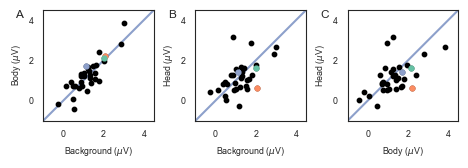

In [121]:
# plot the correlation matrices for the reply to the reviewers
# set fontsize: 
new_height_cm = 6.39  # 1 column = 3.09; 1.5 columns = 4.22; 2 columns = 6.39
original_height_cm = 12 # adjust
original_fontsize = 40
# define
numbersize = 80 * (new_height_cm/60)# A, B etc.
labelsize = 40  * (new_height_cm/40)#text
legendsize = 40  * (new_height_cm/40)#ledgend
ticksize = 30  * (new_height_cm/30)#ticks
fname = "Arial" # font name

# set figure size
fig_width_cm = 11.6  # 1 column = 8.5; 1.5 columns = 11.6; 2 columns = 17.6
fig_width_in = fig_width_cm / 2.54
aspect_ratio = 30/30
fig_height_in = fig_width_in * aspect_ratio

plt.figure(figsize=(fig_width_in, fig_height_in), constrained_layout=True)

sns.set_style("white") 
# grid to have the subplots arranged nicely
ax1 = plt.subplot2grid(shape=(1,3), loc=(0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(shape=(1,3), loc=(0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid(shape=(1,3), loc=(0, 2), rowspan=1, colspan=1)

ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')
ax2.set_aspect(1.0/ax2.get_data_ratio(), adjustable='box')
ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')

chan = 'PO7'
chanlocs = scipy.io.loadmat(f"/net/store/nbp/projects/wd_ride_village/Analysis/FacePaper/ERPs_without_Unfold/TFCE_resources/chanLocs.mat")
chanlocs = chanlocs['chanLocs']
chanlocs = np.array([item[0][:] for item in chanlocs['labels'][0]]).tolist()
chanidx = chanlocs.index(chan) # index

mat = scipy.io.loadmat(f"{PATH_EEG}/FacePaper_ERPData_Full.mat") 
sacc_bgrd = pd.DataFrame(mat['sacc_bgrd'][chanidx,:,:])
sacc_body = pd.DataFrame(mat['sacc_body'][chanidx,:,:])
sacc_head = pd.DataFrame(mat['sacc_head'][chanidx,:,:])

ts = mat['times'][0].tolist()
# taking the mean of the interval 150:170
# taking the peak out of the interval 100:220
time = ts[ts.index(list(filter(lambda i: i >= 150, ts))[0]) : ts.index(list(filter(lambda i: i <= 170, ts))[-1])+ 1]  
bgrd = sacc_bgrd.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()
body = sacc_body.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()
head = sacc_head.iloc[ts.index(time[0]) : (ts.index(time[-1]) + 1)].mean().tolist()

# bgrd vs body
ax1.plot([-2,5],[-2,5],color=head_color, zorder=0)
ax1.scatter(bgrd,body,color='k',s=10)
ax1.set_xlabel(u'Background ($\it{\u03bc}$V)', fontsize=labelsize, fontname=fname)
ax1.set_ylabel(u'Body ($\it{\u03bc}$V)', fontsize=labelsize, fontname=fname)


# brgd vs head
ax2.plot([-2,5],[-2,5],color=head_color, zorder=0)
ax2.scatter(bgrd,head,color='k',s=10)
ax2.set_xlabel(u'Background ($\it{\u03bc}$V)', fontsize=labelsize, fontname=fname)
ax2.set_ylabel(u'Head ($\it{\u03bc}$V)', fontsize=labelsize, fontname=fname)

# body vs head
ax3.plot([-2,5],[-2,5],color=head_color, zorder=0)
ax3.scatter(body,head,color='k',s=10)
ax3.set_xlabel(u'Body ($\it{\u03bc}$V)', fontsize=labelsize, fontname=fname)
ax3.set_ylabel(u'Head ($\it{\u03bc}$V)', fontsize=labelsize, fontname=fname)



## add the idv subjects to the scatterplot 
subj = [27,18,20,]
col = [body_color,bgrd_color,head_color]
for su,sub in enumerate(subj):
    ax1.scatter(bgrd[sub],body[sub],color=col[su],s=12)
    ax2.scatter(bgrd[sub],head[sub],color=col[su],s=12)
    ax3.scatter(body[sub],head[sub],color=col[su],s=12)

# set plot layout
axis = [ax1,ax2,ax3]
for s in range(3):
    axis[s].set_xlim(-1, 4.5)
    axis[s].set_ylim(-1, 4.5)
    #ticks = [-1,0,1,2,3,4]
    ticks = [0,2,4]
    axis[s].set_xticks(ticks)
    axis[s].set_yticks(ticks)
    for label in axis[s].get_xticklabels(): # change tick font
        label.set_fontproperties(fname)
    for label in axis[s].get_yticklabels():
        label.set_fontproperties(fname)
    axis[s].yaxis.set_tick_params(labelsize=ticksize)  # change tick size
    axis[s].xaxis.set_tick_params(labelsize=ticksize)


ax1.set_title("A", fontsize=numbersize, fontweight="bold",loc="left", x=-0.25, y=1.3, pad=-30, fontname=fname) 
ax2.set_title("B", fontsize=numbersize, fontweight="bold",loc="left", x=-0.25, y=1.3, pad=-30, fontname=fname) 
ax3.set_title("C", fontsize=numbersize, fontweight="bold",loc="left", x=-0.25, y=1.3, pad=-30, fontname=fname) 

plt.savefig("./images/Figure3_corr.png", bbox_inches="tight", pad_inches=0, dpi=400) # proper one!
plt.show()

# Nr of Gaze events for representative subjects

In [140]:
### Number of Gaze Events:
ids = recordings.index.tolist()
idd = ids[:]
subj = [27,18,20,]

trial_count = {}
trial_count['bgnd'] = {}
trial_count['body'] = {}
trial_count['head'] = {}
for s in subj:
    lat = pd.read_csv(f"{PATH_TRG}/try_TriggerFile_saccadeOnset_{idd[s]}.csv", index_col=0)
    # 2 for background, 1 for NPCs and 0 for faces
    trial_count['bgnd'][idd[s]] = len(lat[lat['type'] == 2])
    trial_count['body'][idd[s]] = len(lat[lat['type'] == 1])
    trial_count['head'][idd[s]] = len(lat[lat['type'] == 0])

trial_count = pd.DataFrame(trial_count)

# display the statistics
display(trial_count)


,bgnd,body,head
ac35237b-e4b2-4744-bd17-02f44c3f6139,3779,747,194
6264954d-ddee-4eff-b8d6-887fb28524f9,3802,609,151
312425d7-bb57-49dc-9107-b6462b3c176c,3797,792,361
